# PLOTS FOR THE PAPER:
### This Notebook contains:
## Figure 1: Model Validation
    - Timeseries of daily maximum temperatures in ERA5 and WRF
    - Timeseries of Observed Temperatures in Lytton, ERA5 and WRF
    - (MAP)Temperature Anomalies and GPH contours of region in ERA and WRF 
    
## Figure 2: Model Differences
    - Maps of Radiation, 2m Temperature Differences between June and August (with gph difference contours)
    - Timeseries of Radiation, 2m Temperature Differences between June and August and June and July
    
## Figure 3: Records Broken
    - Maps with contours of records broken using an ERA5 climatology
    - Maps of 2m maximum temperature differences
    
## Figure 4: Sensitivity Studies
    - Record exceedance plots for LSM, CAM and Initialisation Sensitivity Runs using the +60day run
    - Maximum Temperature Difference Plots for the same runs

In [1]:
#import libraries
import pandas as pd
import numpy as np
import netCDF4
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature

In [3]:
#set up for wrf and era
variables_wrf = ['T2', 'SWDNT']
variables_era = ['mx2t']
variables_era_gph = ['z']
variables_wrf_gph = ['gph', 'temp']
temperature_variables_era = ["t2m"]

In [4]:
#grab data
#for wrf v era
era_gph = xr.open_dataset('/scratch/rwhite/ladmasu/insol/era5_geopotential_hourly_JJ_2021.nc')
era_reg = xr.open_dataset("/scratch/rwhite/ladmasu/insol/era5_t2m_hourly_1940-2021_PNW_JJA.nc")


#3D DATA
#note: these are regridded to era coordinates which means that you have to specify top then bottom
#is at the north pole and we have 0-360 degrees in latitude
june = xr.open_dataset('/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/june_d02_reproj_rrtmg_regrid_3d.nc')
july = xr.open_dataset('/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/july_d02_reproj_rrtmg_regrid_3d.nc')
aug = xr.open_dataset('/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/aug_d02_reproj_rrtmg_regrid_3d.nc')

#2D DATA
june_2d = xr.open_dataset("/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/june_d02_timemerge_rrtmg_regrid2d.nc")
july_2d = xr.open_dataset("/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/jul_d02_timemerge_rrtmg_regrid2d.nc")
aug_2d = xr.open_dataset("/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/aug_d02_timemerge_rrtmg_regrid2d.nc")

#DATA FOR RECORDS
june_2dregrid = xr.open_dataset("/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/june_d02_timemerge_rrtmg_regridera2d.nc")
aug_2dregrid = xr.open_dataset("/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/aug_d02_timemerge_rrtmg_regridera2d.nc")
july_2dregrid = xr.open_dataset("/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/rrtmg_radiation/jul_d02_timemerge_rrtmg_regridera2d.nc")

weights = np.cos(np.deg2rad(june_2d.sel(lat = slice(45,52)).lat))
weighted_weights = weights/np.mean(weights)


mask_file = xr.open_dataset('/scratch/rwhite/ladmasu/insol/better_mask_regrid.nc')
mask = (mask_file/mask_file).sel(latitude = slice(40,65), longitude = slice(-140, -100)).mean(dim = "time").t2m

In [5]:
#DATA FOR SENSITIVITY STUDIES
june_minus2 =xr.open_dataset('/scratch/rwhite/ladmasu/insol/sensitivity/june_minus2_d02_timemerge_regridera2d.nc')
aug_minus2 = xr.open_dataset('/scratch/rwhite/ladmasu/insol/sensitivity/aug_minus2_d02_timemerge_regridera2d.nc')
cam_june = xr.open_dataset("/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/cam_radiation/june_d02_timemerge_cam_regridera.nc")
cam_aug = xr.open_dataset("/scratch/rwhite/ladmasu/insol/new_dat/BIAS_FIXED/cam_radiation/aug_d02_timemerge_cam_regridera.nc")
aug_noah = xr.open_dataset("/scratch/rwhite/ladmasu/insol/sensitivity/aug_oldNOAHLSM-rrtmg_d02_timemerge_regridera2d.nc")
june_noah = xr.open_dataset("/scratch/rwhite/ladmasu/insol/sensitivity/june_oldNOAHLSM-rrtmg_d02_timemerge_regridera2d.nc")

In [6]:
#actual obs
era = era_reg.sel(time = slice('2021-06-24T03:00:00',"2021-07-05T00:00:00"))
station_lyt = pd.read_csv("/scratch/rwhite/jrobs12/observed_data/lytton_new.csv")

In [42]:
#define plotting functions (I've changed the alpha on the borders to 0.5 for the contour plots)
def set_ax(ax,longrids,latgrids,province=False):
    resol = '50m'
    provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
                name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='k', alpha = 0.5)

    ax.set_extent([lon_extent[0], lon_extent[1], lat_extent[0], lat_extent[1]])
    if province:
        ax.add_feature(provinc_bodr, linestyle='-', linewidth=1.5, edgecolor="k", zorder=10, alpha = 0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=1.5)
    #ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.OCEAN, color = 'lightcyan')
    ax.set_aspect('auto')
    #gl = ax.gridlines(draw_labels = True, alpha=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False, alpha = 0.5, linestyle = "dashed")
    gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
    gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
    gl.xlabel_style = {'rotation': 0, 'fontsize':14}
    gl.top_labels = None
    gl.right_labels = None
    
    gl.xlabel_style = {'color': 'gray', 'fontsize':16}
    gl.ylabel_style = {'color': 'gray', 'fontsize':16}

    return(ax)

def set_ax_overview(ax,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=False):
    resol = '50m'
    provinc_bodr = cartopy.feature.NaturalEarthFeature(category='cultural', 
                name='admin_1_states_provinces_lines', scale=resol, facecolor='none', edgecolor='silver', alpha = 0.5)

    ax.set_extent([lon_extent[0], lon_extent[1], lat_extent[0], lat_extent[1]])
    if province:
        ax.add_feature(provinc_bodr, linestyle='-', linewidth=1.5, edgecolor="k", zorder=10, alpha = 0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=1.5)
    #ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.OCEAN, color = 'lightblue')
    ax.set_aspect('auto')
    #gl = ax.gridlines(draw_labels = True, alpha=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=None, y_inline=False)
    gl.ylocator = matplotlib.ticker.FixedLocator(latgrids)
    gl.xlocator = matplotlib.ticker.FixedLocator(longrids)
    gl.xlabel_style = {'rotation': 0}
    gl.top_labels = None
    gl.right_labels = None

    gl.xlabel_style = {'color': 'gray', 'fontsize':16}
    gl.ylabel_style = {'color': 'gray', 'fontsize':16}
    
    return(ax)

In [8]:
### Functions
def get_colormaps():
    # Define new colormap with white centre
    reds = np.array([10,15,30,60,80,130,160,200,230,255,255,255,255,255,255,255,255,255,192,165],float)
    greens = np.array([50,75,110,160,180,210,240,250,255,255,255,250,232,192,160,96,50,20,0,0],float)
    blues = np.array([120,165,200,240,250,255,255,255,255,255,255,220,120,60,0,0,0,0,0,0],float)

    reds = reds/255
    blues = blues/255
    greens = greens/255

    ncolors = len(reds)

    spacing = np.linspace(0,1,ncolors)
    cdict = {'red': ((spacing[0], reds[0], reds[0]),
                     (spacing[1], reds[1], reds[1]),
                     (spacing[2], reds[2], reds[2]),
                     (spacing[3], reds[3], reds[3]),
                     (spacing[4], reds[4], reds[4]),
                     (spacing[5], reds[5], reds[5]),
                     (spacing[6], reds[6], reds[6]),
                     (spacing[7], reds[7], reds[7]),
                     (spacing[8], reds[8], reds[8]),
                     (spacing[9], reds[9], reds[9]),
                     (spacing[10], reds[10], reds[10]),
                     (spacing[11], reds[11], reds[11]),
                     (spacing[12], reds[12], reds[12]),
                     (spacing[13], reds[13], reds[13]),
                     (spacing[14], reds[14], reds[14]),
                     (spacing[15], reds[15], reds[15]),
                     (spacing[16], reds[16], reds[16]),
                     (spacing[17], reds[17], reds[17]),
                     (spacing[18], reds[18], reds[18]),
                     (spacing[19], reds[19], reds[19])
                    ),
             'green': ((spacing[0], greens[0], greens[0]),
                     (spacing[1], greens[1], greens[1]),
                     (spacing[2], greens[2], greens[2]),
                     (spacing[3], greens[3], greens[3]),
                     (spacing[4], greens[4], greens[4]),
                     (spacing[5], greens[5], greens[5]),
                     (spacing[6], greens[6], greens[6]),
                     (spacing[7], greens[7], greens[7]),
                     (spacing[8], greens[8], greens[8]),
                     (spacing[9], greens[9], greens[9]),
                     (spacing[10], greens[10], greens[10]),
                     (spacing[11], greens[11], greens[11]),
                     (spacing[12], greens[12], greens[12]),
                     (spacing[13], greens[13], greens[13]),
                     (spacing[14], greens[14], greens[14]),
                     (spacing[15], greens[15], greens[15]),
                     (spacing[16], greens[16], greens[16]),
                     (spacing[17], greens[17], greens[17]),
                     (spacing[18], greens[18], greens[18]),              
                     (spacing[19], greens[19], greens[19]) 
                      ),
                       
             'blue': ((spacing[0], blues[0], blues[0]),
                     (spacing[1], blues[1], blues[1]),
                     (spacing[2], blues[2], blues[2]),
                     (spacing[3], blues[3], blues[3]),
                     (spacing[4], blues[4], blues[4]),
                     (spacing[5], blues[5], blues[5]),
                     (spacing[6], blues[6], blues[6]),
                     (spacing[7], blues[7], blues[7]),
                     (spacing[8], blues[8], blues[8]),
                     (spacing[9], blues[9], blues[9]),
                     (spacing[10], blues[10], blues[10]),
                     (spacing[11], blues[11], blues[11]),
                     (spacing[12], blues[12], blues[12]),
                     (spacing[13], blues[13], blues[13]),
                     (spacing[14], blues[14], blues[14]),
                     (spacing[15], blues[15], blues[15]),
                     (spacing[16], blues[16], blues[16]),
                     (spacing[17], blues[17], blues[17]),
                     (spacing[18], blues[18], blues[18]),               
                     (spacing[19], blues[19], blues[19])                 
                     )}

    cmap_wc = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

    reds = np.array([  10, 15, 30, 60, 80,130,160,200,230,245,255,255,255,255,255,255,255,192,165],float)
    greens = np.array([50, 75,110,160,180,210,240,250,255,245,250,232,192,160, 96, 50, 20,  0,  0],float)
    blues = np.array([120,165,200,240,250,255,255,255,255,245,220,120, 60,  0,  0,  0,  0,  0,  0],float)

    reds = reds/255
    blues = blues/255
    greens = greens/255

    ncolors = len(reds)

    spacing = np.linspace(0,1,ncolors)
    cdict = {'red': ((spacing[0], reds[0], reds[0]),
                     (spacing[1], reds[1], reds[1]),
                     (spacing[2], reds[2], reds[2]),
                     (spacing[3], reds[3], reds[3]),
                     (spacing[4], reds[4], reds[4]),
                     (spacing[5], reds[5], reds[5]),
                     (spacing[6], reds[6], reds[6]),
                     (spacing[7], reds[7], reds[7]),
                     (spacing[8], reds[8], reds[8]),
                     (spacing[9], reds[9], reds[9]),
                     (spacing[10], reds[10], reds[10]),
                     (spacing[11], reds[11], reds[11]),
                     (spacing[12], reds[12], reds[12]),
                     (spacing[13], reds[13], reds[13]),
                     (spacing[14], reds[14], reds[14]),
                     (spacing[15], reds[15], reds[15]),
                     (spacing[16], reds[16], reds[16]),
                     (spacing[17], reds[17], reds[17]),
                     (spacing[18], reds[18], reds[18])
                    ),
             'green': ((spacing[0], greens[0], greens[0]),
                     (spacing[1], greens[1], greens[1]),
                     (spacing[2], greens[2], greens[2]),
                     (spacing[3], greens[3], greens[3]),
                     (spacing[4], greens[4], greens[4]),
                     (spacing[5], greens[5], greens[5]),
                     (spacing[6], greens[6], greens[6]),
                     (spacing[7], greens[7], greens[7]),
                     (spacing[8], greens[8], greens[8]),
                     (spacing[9], greens[9], greens[9]),
                     (spacing[10], greens[10], greens[10]),
                     (spacing[11], greens[11], greens[11]),
                     (spacing[12], greens[12], greens[12]),
                     (spacing[13], greens[13], greens[13]),
                     (spacing[14], greens[14], greens[14]),
                     (spacing[15], greens[15], greens[15]),
                     (spacing[16], greens[16], greens[16]),
                     (spacing[17], greens[17], greens[17]),
                     (spacing[18], greens[18], greens[18])
                     ),

            'blue': ((spacing[0], blues[0], blues[0]),
                     (spacing[1], blues[1], blues[1]),
                     (spacing[2], blues[2], blues[2]),
                     (spacing[3], blues[3], blues[3]),
                     (spacing[4], blues[4], blues[4]),
                     (spacing[5], blues[5], blues[5]),
                     (spacing[6], blues[6], blues[6]),
                     (spacing[7], blues[7], blues[7]),
                     (spacing[8], blues[8], blues[8]),
                     (spacing[9], blues[9], blues[9]),
                     (spacing[10], blues[10], blues[10]),
                     (spacing[11], blues[11], blues[11]),
                     (spacing[12], blues[12], blues[12]),
                     (spacing[13], blues[13], blues[13]),
                     (spacing[14], blues[14], blues[14]),
                     (spacing[15], blues[15], blues[15]),
                     (spacing[16], blues[16], blues[16]),
                     (spacing[17], blues[17], blues[17]),
                     (spacing[18], blues[18], blues[18]) 
                     )}

    cmap_def = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

    # Define new colormap
    reds = np.array([ 245,255,255,255,255,255,255,255,192,165],float)
    greens = np.array([245,250,232,192,160,96,50,20,0,0],float)
    blues = np.array([245,220,120,60,0,0,0,0,0,0],float)

    reds = reds/255
    blues = blues/255
    greens = greens/255

    ncolors = len(reds)

    spacing = np.linspace(0,1,ncolors)
    cdict = {'red': ((spacing[0], reds[0], reds[0]),
                     (spacing[1], reds[1], reds[1]),
                     (spacing[2], reds[2], reds[2]),
                     (spacing[3], reds[3], reds[3]),
                     (spacing[4], reds[4], reds[4]),
                     (spacing[5], reds[5], reds[5]),
                     (spacing[6], reds[6], reds[6]),
                     (spacing[7], reds[7], reds[7]),
                     (spacing[8], reds[8], reds[8]),
                     (spacing[9], reds[9], reds[9])
                    ),
             'green': ((spacing[0], greens[0], greens[0]),
                     (spacing[1], greens[1], greens[1]),
                     (spacing[2], greens[2], greens[2]),
                     (spacing[3], greens[3], greens[3]),
                     (spacing[4], greens[4], greens[4]),
                     (spacing[5], greens[5], greens[5]),
                     (spacing[6], greens[6], greens[6]),
                     (spacing[7], greens[7], greens[7]),
                     (spacing[8], greens[8], greens[8]),
                     (spacing[9], greens[9], greens[9])
                     ),
                       
             'blue': ((spacing[0], blues[0], blues[0]),
                     (spacing[1], blues[1], blues[1]),
                     (spacing[2], blues[2], blues[2]),
                     (spacing[3], blues[3], blues[3]),
                     (spacing[4], blues[4], blues[4]),
                     (spacing[5], blues[5], blues[5]),
                     (spacing[6], blues[6], blues[6]),
                     (spacing[7], blues[7], blues[7]),
                     (spacing[8], blues[8], blues[8]),
                     (spacing[9], blues[9], blues[9]) 
                     )}

    cmap_reds = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return(cmap_def,cmap_wc,cmap_reds)

# Create nice colorbars
cmap_def, cmap_wc, cmap_reds = get_colormaps()
def heatwave_box(color = "black"):
    """plots heatwave box on grid using above functions"""
    lons = [-119, -123]
    lats = [45, 52]
    plt.plot([lons[0], lons[0]], [lats[1], lats[0]],color=color, transform=ccrs.PlateCarree())
    plt.plot([lons[1], lons[1]], [lats[1], lats[0]],color=color, transform=ccrs.PlateCarree())
    plt.plot([lons[1], lons[0]], [lats[1], lats[1]],color=color, transform=ccrs.PlateCarree())
    plt.plot([lons[1], lons[0]], [lats[0], lats[0]],color=color, transform=ccrs.PlateCarree())
    
def add_labels(ax,fontsize, color = 'k'):
    """adds the state and province labels to the plots"""
    ax.text(-134, 59.0, 'BC', transform=ccrs.PlateCarree(), fontsize=fontsize)
    ax.text(-119.5, 59.25, 'AB', transform=ccrs.PlateCarree(), fontsize=fontsize)
    ax.text(-124.2, 47.4, 'WA', transform=ccrs.PlateCarree(), fontsize=fontsize)
    ax.text(-123.7, 45.3, 'OR', transform=ccrs.PlateCarree(), fontsize=fontsize)
def records_area(records_broken, model_june, model, threshold, area_path, land_ocean_mask):
    area_dat = xr.open_dataset(area_path)
    area = area_dat.cell_area.sel(latitude = slice(65,40), longitude = slice(-140,-100)) #find PNW
    mask = land_ocean_mask
    #find area
    records = records_broken - (model_june-model)
    records_land = mask.values*records.copy()
    #make normalised map of places (not ocean) where records were broken
    plot = records_land/records_land
    #calcualte area where records were broken
    area_rev = area.reindex(latitude=list(reversed(area.latitude)))
    area_above_threshold = area_rev.where(records_land>threshold,0).sum()/1000**2 #in km^2
    return(area_above_threshold, plot)

In [9]:
#TIME COORDINATES (FOR THE OBSERVATIONS PLOTS)
#find indices
#(WRF)
#input the start and end date/time object
multiple_day_wrf = True
time_point = "2021-06-26T12:00:00"
last_time_point = "2021-06-30T12:00:00" #only use this for multiple days

if multiple_day_wrf == True:
    t1 = time_point
    t2 = last_time_point
    first_coord = june.Time.sel(Time = t1)
    last_coord = june.Time.sel(Time = t2)
    index = np.logical_and(june.Time >= first_coord, june.Time <= last_coord )
    indices = np.where(index)
if multiple_day_wrf == False:
    t = time_point
    coord = june.Time.sel(Time = t)
    index = june.Time == coord
    indices = np.where(index)

#day specfic (ONLY for WRF)
day_one = indices[0][:12]
day_two = indices[0][12:36]
day_three = indices[0][36:60]
day_four = indices[0][60:84]
day_five = indices[0][84:-1]

#ERA5 Temp
#do the same thing to era5 max temp
multiple_day_era = True

if multiple_day_era == True:
    t3 = time_point
    t4 = last_time_point
    first_coord_era = era.time.sel(time = t3)
    last_coord_era = era.time.sel(time = t4)
    index_era = np.logical_and(era.time >= first_coord_era, era.time <= last_coord_era)
    indices_era = np.where(index_era)[0]
if multiple_day_era == False:
    t = time_point
    coord_era = era.time.sel(time = t)
    index_era = era.time == coord_era
    indices_era = np.where(index_era)
    
#ERA5 GPH
#do the same thing for era's gph dataset
era_gph_multiple_day = True

if era_gph_multiple_day == True:
    t5 = time_point
    t6 = last_time_point
    first_coord_era_gph = era_gph.time.sel(time = t5)
    last_coord_era_gph = era_gph.time.sel(time = t6)
    index_era_gph = np.logical_and(era_gph.time >= first_coord_era_gph, era_gph.time <= last_coord_era_gph)
    indices_era_gph = np.where(index_era_gph)
if era_gph_multiple_day == False:
    t = time_point
    coord_era_gph = era_gph.time.sel(time = t)
    index_era_gph = era_gph.time == coord_era_gph
    indices_era_gph = np.where(index_era_gph)

## Figure 1

In [10]:
#Maximum Temperatures for maps
#find june daily maximums in time domain
june_anom_bc = june_2dregrid.sel(latitude = slice(63,41), longitude = slice(-150, -105), XTIME = june_2dregrid.XTIME[indices[0]])
june_max_daily = june_anom_bc.resample(XTIME = "1D").max() #resample to daily max
june_max = june_max_daily.mean(dim = "XTIME") - 273.15

#find june daily maximums in time domain for ERA5
era_anom_bc = era_reg.sel(latitude = slice(41,63), longitude = slice(-150, -105), time = slice("2021-06-26", '2021-06-30'))
era_max_daily = era_anom_bc.resample(time = "1D").max() #resample to daily max
era_max = era_max_daily.mean(dim = "time") - 273.15

# WRF contours setup
wrf_bc_june = june[variables_wrf_gph].sel(lon = slice(-145,-95), lat = slice(41,63), level = 500)
wrf_bc_map_june = wrf_bc_june.sel(Time = june.Time[indices])
wrf_june_mean = wrf_bc_map_june.mean(dim = "Time")
june_gph = wrf_june_mean.gph*10 #go from dm tp m

latitudes = june_gph.lat
longitudes = june_gph.lon

# ERA contours setup
era_bc_gph = era_gph.sel(longitude = slice(-145,-95), latitude = slice(63,41))
era_bc_map_gph = era_bc_gph.sel(time = era_gph.time[indices_era_gph])
era_june_mean_gph = era_bc_map_gph.mean(dim = "time")
era_gph_heatwave = era_june_mean_gph.z/9.81 #go from m^2/s^2 to m

latitudes_era = era_gph_heatwave.latitude
longitudes_era = era_gph_heatwave.longitude

In [11]:
#Plotting Numbers
central_lon = 240
central_lat = 39.0

lon_extent = [-135,-110]
lat_extent = [42,60]
latgrids=[40,45,50,55,60,65,70]
longrids=[-125,-115]

fontsize = 16
fontsize_labels = 14

In [12]:
##WRF and ERA temperature Time series

#weights
era_weights = np.cos(np.deg2rad(era_reg.sel(latitude = slice(45,52)).latitude))
era_ww = era_weights/np.mean(era_weights)

weights = june_2d.lat.sel(lat = slice(45,52))
ww = weights/np.mean(weights)

#temperature timeseries
june_ts = (june_2d.sel(lat = slice(45,52), lon = slice(-123,-119)).mean(dim = "lon")*ww).mean(dim = 'lat')
june_temp = june_ts.T2 - 273.15


era_reg_bc = era_reg[temperature_variables_era].sel(latitude = slice(45,52), 
                                                    longitude = slice(-123,-119), time = slice('2021-06-24', '2021-07-05'))
era_w = era_reg_bc.mean(dim = ["longitude"]).groupby('latitude')*era_ww
era_bcts = era_w.mean(dim = "latitude")
era_temps = era_bcts.t2m - 273.15

#time
era_time = era_bcts.time
time = june_2d.XTIME

In [13]:
#define temperature datasets
wrf = june_2d
era_t = era.t2m - 273.15 #find temperatures in Celcius
wrf_t = wrf.T2 - 273.15

#station temperature
station_lyt_temp = station_lyt["Temp (°C)"].values 

#find different times for each dataset
time = wrf.XTIME

#environment Canada Data
#need to start on June 24th at 03:00 UTC
station_time = station_lyt["Date/Time (UTC)"].values
last_station_time = station_time[-1] #know when our last datapoint was
first_coord = wrf.XTIME.sel(XTIME = "2021-06-24T03:00:00", method = "nearest").values
last_coord = wrf.XTIME.sel(XTIME = '2021-06-30T23:00:21.679687500', method = "nearest").values
start_index,stop_index = np.where(time == first_coord)[0][0], np.where(time == last_coord)[0][0]
env_can_temp_start = np.where(station_time == '2021-06-24 03:00')[0][0]

#find stations
lyt_cord = [-121.57, 50.22]
wrf_lyt = wrf_t.sel(lon = lyt_cord[0], lat = lyt_cord[1], method = "nearest")
era_lyt = era_t.sel(longitude = lyt_cord[0], latitude = lyt_cord[1], method = "nearest")

In [14]:
#Finding Elevations for Lapse Rate Correction
#Import data
lyt_elevation = xr.open_dataset("/scratch/rwhite/ladmasu/insol/june_d02_lytton_HGT.nc")
era_elevation = xr.open_dataset("/scratch/rwhite/ladmasu/insol/era5_geopotential_surface_2021.nc")

##ELEVATIONS
height_at_lyt = lyt_elevation.HGT
era_height_at_lyt = era_elevation.sel(latitude = 50.2217, longitude = 360-121.5727, method = "nearest").z #m^2/s^2
era_height = era_height_at_lyt.values/9.81

In [15]:
#corrected temperatures
wrf_elevation_lyt = 908.333 #m
era_elevation_lyt = 1332.0729 #m
elevation_lyt = 225 #m
lapse = 6.5/1000 #K/m

#find the correction factor
correction_wrf2 = lapse*(wrf_elevation_lyt - elevation_lyt)
correction_era2 = lapse*(era_elevation_lyt- elevation_lyt)
#apply correction
wrf_corrected_temperatures2 = wrf_lyt+correction_wrf2
era_corrected_temperatures2 = era_lyt+correction_era2

In [ ]:
#### FIGURE 1 CODE #### 
plt.suptitle("FIGURE 1")
fig = plt.figure(figsize=(20,10))

## ERA Max T with contours
ax1 = plt.subplot(2,3,1, projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
add_labels(ax1, 10)
ax1.set_title("A) ERA5 2-m Max T and Z500", fontsize=fontsize, loc = "left")
ax1 = set_ax_overview(ax1,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)

j = plt.contourf((era_max).longitude, (era_max).latitude, (era_max).t2m.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_reds,extend='both', levels = np.arange(20,52,2), add_colorbar = False)
levels = np.arange(5700,6000,40)
h = plt.contour(longitudes_era ,latitudes_era ,era_gph_heatwave.values, transform=ccrs.PlateCarree(),
                                    colors = "k", levels = levels)
ax1.clabel(h,levels, inline=True, fontsize=10, fmt = "%3.0f")

heatwave_box('deepskyblue')
plt.scatter(-121.5727, 50.2217, marker = "*", color = "deepskyblue", transform = ccrs.PlateCarree())


## WRF Max T with contours
ax2 = plt.subplot(2,3,2, projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax2.set_title("B) WRF 2-m Max T and Z500", fontsize= fontsize, loc = "left")
add_labels(ax2, 10)
ax2 = set_ax_overview(ax2,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)

j = plt.contourf(june_max.longitude, june_max.latitude,june_max.T2.values, 
                 cmap = cmap_reds,extend='both', levels = np.arange(20,52,2), transform = ccrs.PlateCarree())
levels = np.arange(5700,6000,40)
h = plt.contour(longitudes ,latitudes, june_gph.values, transform=ccrs.PlateCarree(),
                                    colors = "k", levels = levels)
ax2.clabel(h,levels, fontsize=10,fmt = "%3.0f")

#make colorbar
cx = fig.add_axes([0.65, 0.55, 0.01, 0.3])
cbar = fig.colorbar(j, extend = "both", shrink = 0.8, cax = cx).set_label(label = "2m TXx (\N{DEGREE SIGN}C)",size = fontsize_labels)

## Heatwave Box 2m Temperature Timeseries
ax3 = plt.subplot(2,3,4)
ax3.set_title("C) 2-m T over Heatwave Region", fontsize = fontsize, loc = "left")

plt.plot(time, june_temp, label = "WRF", color = 'red')
plt.plot(era_time, era_temps, label = "ERA5", color = 'deepskyblue')

ax3.axvline("2021-06-26T12:00:00", color = 'k', linestyle = "dashed")
ax3.axvline("2021-06-30T12:00:00", color = "k", linestyle = "dashed")

ticks_loc = np.array([18803.+0.33, 18805.+0.33, 18807.+0.33, 18809.+0.33, 18811.+0.33, 18813.+0.33])
ticks_names = ['06-24','06-26', '06-28', '06-30', '07-02', '07-04'];#ticks_loc, ticks_names
plt.xticks(ticks_loc, ticks_names, fontsize = 13)

plt.ylabel("2m Temperature (\N{DEGREE SIGN}C)", fontsize = fontsize_labels)
plt.legend()

## 2m Temperature Timeseries at Lytton, BC
ax4 = plt.subplot(2,3,5)
ax4.set_title("D) 2-m T at Lytton", fontsize = fontsize, loc = "left")

h = plt.plot(time, era_corrected_temperatures2, color = "navy", label = "ERA5")
plt.plot(time, wrf_corrected_temperatures2, label = "WRF", color = "red")
plt.plot(time[:stop_index+1], station_lyt_temp[env_can_temp_start:], label = "Observed", color = "orange")

plt.legend(loc = "upper right")
plt.ylabel("2m Temperature (\N{DEGREE SIGN}C)", fontsize = fontsize_labels)

ticks_loc = np.array([18803.+0.33, 18805.+0.33, 18807.+0.33, 18809.+0.33, 18811.+0.33, 18813.+0.33])
ticks_names = ['06-24','06-26', '06-28', '06-30', '07-02', '07-04'];#ticks_loc, ticks_names
plt.xticks(ticks_loc, ticks_names, fontsize = 13);

plt.savefig("figure1.png")

/scratch/rwhite/jrobs12/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/tmp/98734.admin.default.domain/ipykernel_1616/2365567640.py:39: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(j, extend = "both", shrink = 0.8, cax = cx).set_label(label = "2m TXx (\N{DEGREE SIGN}C)",size = fontsize_labels)


<Figure size 640x480 with 0 Axes>

## Figure 2

In [24]:
#radiation differences (map) - +60
june_swdb = june_2d.sel(XTIME = june_2d.XTIME[indices]).SWDNB.mean(dim = "XTIME")
aug_swdb = aug_2d.sel(XTIME = aug_2d.XTIME[indices]).SWDNB.mean(dim = "XTIME")
diff_swdb_aug = june_swdb - aug_swdb.values

#radiation differences (map) - +30
july_swdb = july_2d.sel(XTIME = july_2d.XTIME[indices]).SWDNB.mean(dim = "XTIME")
diff_swdb = june_swdb - july_swdb.values

#Temperature Differences (Maps)
june_t2 = june_2d.sel(XTIME = june_2d.XTIME[indices]).T2.mean(dim = "XTIME")
july_t2 = july_2d.sel(XTIME = july_2d.XTIME[indices]).T2.mean(dim = "XTIME")
aug_t2 = aug_2d.sel(XTIME = aug_2d.XTIME[indices]).T2.mean(dim = "XTIME")

diff_t2 = june_t2 - july_t2.values

diff_t2_aug = june_t2 - aug_t2.values

In [25]:
#radiation timeseries
june_sw_ts = june_2d.sel(lon = slice(-123,119), lat = slice(45,52)).SWDNB.groupby('lat')*weighted_weights
july_sw_ts = july_2d.sel(lon = slice(-123,119), lat = slice(45,52)).SWDNB.groupby('lat')*weighted_weights
aug_sw_ts = aug_2d.sel(lon = slice(-123,119), lat = slice(45,52)).SWDNB.groupby('lat')*weighted_weights

june_sw_tsw = june_sw_ts.mean(dim = ['lat','lon'])
july_sw_tsw = july_sw_ts.mean(dim = ['lat','lon'])
aug_sw_tsw = aug_sw_ts.mean(dim = ['lat','lon'])

july_diff = june_sw_tsw - july_sw_tsw.values
aug_diff = june_sw_tsw - aug_sw_tsw.values

In [26]:
#temperature timeseries
june_t2_ts = june_2d.sel(lon = slice(-123,119), lat = slice(45,52)).T2.groupby('lat')*weighted_weights
july_t2_ts = july_2d.sel(lon = slice(-123,119), lat = slice(45,52)).T2.groupby('lat')*weighted_weights
aug_t2_ts = aug_2d.sel(lon = slice(-123,119), lat = slice(45,52)).T2.groupby('lat')*weighted_weights

june_t2_tsw = june_t2_ts.mean(dim = ['lat', 'lon'])
july_t2_tsw = july_t2_ts.mean(dim = ['lat', 'lon'])
aug_t2_tsw = aug_t2_ts.mean(dim = ['lat', 'lon'])

july_diff_temp = june_t2_tsw - july_t2_tsw.values
aug_diff_temp = june_t2_tsw - aug_t2_tsw.values

In [27]:
#Geopotential Height Contours
june_gph = june.sel(lon = slice(-145,-95), lat = slice(41,63), Time = june.Time[indices], level = 500).mean(dim = "Time").gph
july_gph = july.sel(lon = slice(-145,-95), lat = slice(41,63), Time = july.Time[indices], level = 500).mean(dim = "Time").gph
aug_gph = aug.sel(lon = slice(-145,-95), lat = slice(41,63), Time = aug.Time[indices], level = 500).mean(dim = "Time").gph

july_gph_diff = (june_gph - july_gph.values)*10 #dm to m 
aug_gph_diff = (june_gph - aug_gph.values)*10 #dm to m

/scratch/rwhite/jrobs12/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/tmp/98734.admin.default.domain/ipykernel_1616/3151634890.py:86: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(j5,extend = "both", shrink = 0.8, cax = cx1,
/tmp/98734.admin.default.domain/ipykernel_1616/3151634890.py:89: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(j6,extend = "both", shrink = 0.8, cax = cx2,


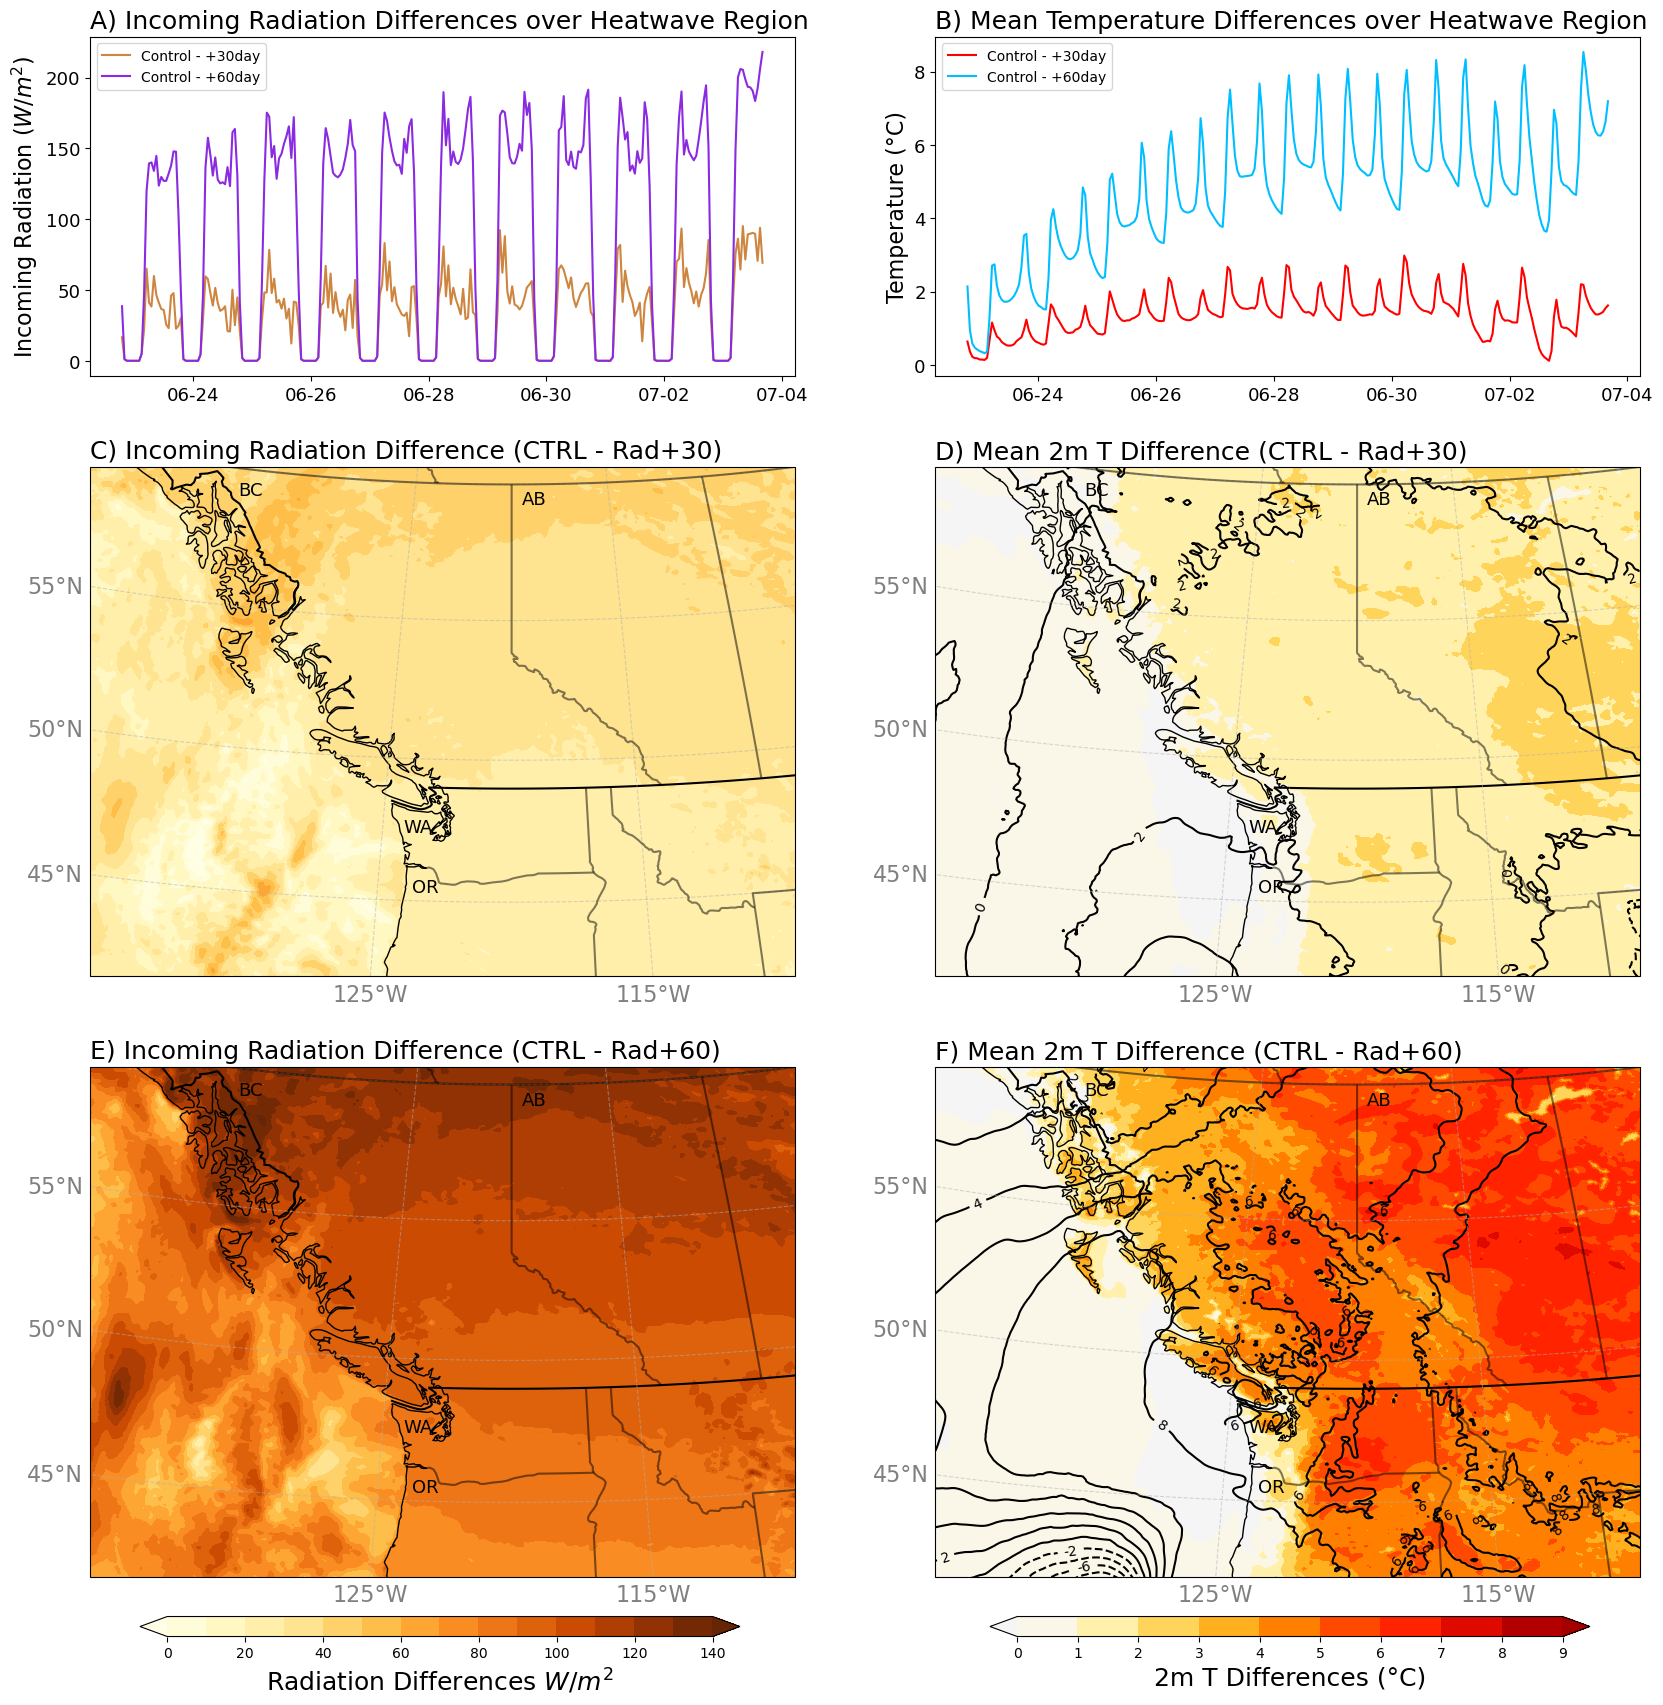

In [34]:
### FIGURE 2 CODE
fontsize = 18
fontsize_labels = 16
levels_gph = np.arange(-10,10,2)
fig = plt.figure(figsize=(20,20))
from matplotlib import gridspec
gs = gridspec.GridSpec(3, 2, height_ratios=[1,1.5,1.5])

## Radiation Difference Timeseries
ax1=plt.subplot(gs[0]) 
ax1.set_title("A) Incoming Radiation Differences over Heatwave Region",loc = "left", fontsize = fontsize)
plt.plot(time, july_diff, label = "Control - +30day", color = 'peru')
plt.plot(time, aug_diff, label = "Control - +60day", color = 'blueviolet')
#plt.plot(ticks_loc, reg_temps-273.15, color = "orange", label = "Climatological Daily Average")
ticks_loc = np.array([18803.+0.33, 18805.+0.33, 18807.+0.33, 18809.+0.33, 18811.+0.33, 18813.+0.33])
ticks_names = ['06-24','06-26', '06-28', '06-30', '07-02', '07-04'];#ticks_loc, ticks_names
plt.xticks(ticks_loc, ticks_names, fontsize = 13);
plt.yticks(fontsize = 13)
plt.ylabel("Incoming Radiation $(W/m^2)$", fontsize = fontsize_labels)
plt.legend()

## Temperature Differences Timeseries
ax2=plt.subplot(gs[1]) 
ax2.set_title("B) Mean Temperature Differences over Heatwave Region",loc = "left", fontsize = fontsize)
plt.xticks(ticks_loc, ticks_names);
plt.plot(time, july_diff_temp, label = "Control - +30day", color = 'red')
plt.plot(time, aug_diff_temp, label = "Control - +60day", color = 'deepskyblue')
ticks_loc = np.array([18803.+0.33, 18805.+0.33, 18807.+0.33, 18809.+0.33, 18811.+0.33, 18813.+0.33])
ticks_names = ['06-24','06-26', '06-28', '06-30', '07-02', '07-04'];#ticks_loc, ticks_names
plt.xticks(ticks_loc, ticks_names, fontsize = 13);
plt.yticks(fontsize = 13)
plt.ylabel("Temperature (\N{DEGREE SIGN}C)", fontsize = fontsize_labels)
plt.legend()

## Control and +30day Map (Radiation)
ax3=plt.subplot(gs[2], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax3.set_title("C) Incoming Radiation Difference (CTRL - Rad+30)",loc = "left", fontsize = fontsize)
ax3 = set_ax(ax3,longrids,latgrids,province=True)

j3 = plt.contourf((diff_swdb).lon, (diff_swdb).lat, (diff_swdb).values, transform=ccrs.PlateCarree(),
                                    cmap = 'YlOrBr',extend='both', levels = np.arange(0,150,10), add_colorbar = False)
add_labels(ax3, 13)


## Control and +60 day (Radiation)
ax5=plt.subplot(gs[4], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax5.set_title("E) Incoming Radiation Difference (CTRL - Rad+60)",loc = "left", fontsize = fontsize)
ax5 = set_ax(ax5,longrids,latgrids,province=True)

j5 = plt.contourf((diff_swdb_aug).lon, (diff_swdb_aug).lat, (diff_swdb_aug).values, transform=ccrs.PlateCarree(),
                                    cmap = 'YlOrBr',extend='both', levels = np.arange(0,150,10), add_colorbar = False)
add_labels(ax5, 13)

## Control and +30day Map (Temperature)
ax4=plt.subplot(gs[3], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax4 = set_ax(ax4,longrids,latgrids,province=True)
ax4.set_title("D) Mean 2-m T Difference (CTRL - Rad+30)",loc = "left", fontsize = fontsize)

j4 = plt.contourf((diff_t2).lon, (diff_t2).lat, (diff_t2).values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_reds,extend='both', levels = np.arange(0,10,1), add_colorbar = False)
h = ax4.contour(longitudes, latitudes, july_gph_diff.values,
            levels = levels_gph,transform=ccrs.PlateCarree(), colors = "k", alpha = 1, linewidths = 1.5) #contour gph differences
ax4.clabel(h,levels_gph, inline=True, fontsize=10, fmt = "%0.0f")
add_labels(ax4, 13)

## Control and 60 day (Temperature)
ax6=plt.subplot(gs[5], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax6.set_title("F) Mean 2-m T Difference (CTRL - Rad+60)",loc = "left", fontsize = fontsize)
ax6 = set_ax(ax6,longrids,latgrids,province=True)

j6 = plt.contourf((diff_t2_aug).lon, (diff_t2_aug).lat, (diff_t2_aug).values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_reds,extend='both', levels = np.arange(0,10,1), add_colorbar = False)
h = ax6.contour(longitudes, latitudes, aug_gph_diff.values, 
            levels = levels_gph,transform=ccrs.PlateCarree(), colors = "k", alpha = 1, linewidths = 1.5) #contour gph differences
ax6.clabel(h,levels_gph, inline=True, fontsize=10, fmt = "%0.0f")
add_labels(ax6, 13)

#make colorbars
cx1 = fig.add_axes([0.15, 0.08, 0.3, 0.01])
cx2 = fig.add_axes([0.575, 0.08, 0.3, 0.01])
#radiation
fig.colorbar(j5,extend = "both", shrink = 0.8, cax = cx1, 
             orientation = 'horizontal').set_label(label = "Radiation Differences $W/m^2$", fontsize = fontsize_labels + 2)
#temperature
fig.colorbar(j6,extend = "both", shrink = 0.8, cax = cx2, 
            orientation = 'horizontal').set_label(label = "2-m T Differences (\N{DEGREE SIGN}C)", fontsize = fontsize_labels+2)
plt.savefig('figure2.png')

### Figure 3

In [35]:
##find records in ERA5 data
era_dailymax = era_reg.resample(time = "1D").max()
#find daily maximum and find the 2021 event in era5
era_daily_max_PNW = era_dailymax.sel(latitude = slice(40,65), longitude = slice(-140,-100), 
                       time = slice("1940-01-01T00:00:00.000000000", "2021-06-01T00:00:00.000000000")).t2m.max(dim = "time")
era_test_hw = era_dailymax.sel(latitude = slice(40,65), longitude = slice(-140, -100), 
                       time = slice("2021-06-26T00:00:00.000000000", "2021-06-30T00:00:00.000000000")).t2m.max(dim = "time")

#find maxes in wrf data
june_max = june_2dregrid.sel(XTIME = june_2d.XTIME[57:153], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")
july_max = july_2dregrid.sel(XTIME = july_2d.XTIME[57:153], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")
aug_max = aug_2dregrid.sel(XTIME = aug_2d.XTIME[57:153], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")

#find records broken during the 2021 event
records_broken = (era_test_hw - era_daily_max_PNW)

In [36]:
#make month arrays (any record exceedance)
june_area2, june_mask2 = records_area(records_broken, june_max, june_max, 0,'/scratch/rwhite/ladmasu/insol/area_gridera.nc', mask)
aug_area2, aug_mask2 = records_area(records_broken, june_max, aug_max, 0,'/scratch/rwhite/ladmasu/insol/area_gridera.nc', mask)
july_area2,july_mask2= records_area(records_broken, june_max, july_max, 0,'/scratch/rwhite/ladmasu/insol/area_gridera.nc', mask)

In [37]:
#make map arrays
#records
control = ((era_test_hw - era_daily_max_PNW) - (june_max - june_max))*june_mask2
plus_30 = ((era_test_hw - era_daily_max_PNW) - (june_max - july_max))*july_mask2
plus_60 = ((era_test_hw - era_daily_max_PNW) - (june_max - aug_max))*aug_mask2

july_diff = (june_max - july_max)*june_mask2
aug_diff = (june_max - aug_max)*june_mask2

In [38]:
#plotting parameters
bounds = np.linspace(0,5,6)
fontsize_PR = 13
fontsize_large = 20

norm = matplotlib.colors.BoundaryNorm(bounds, 30, extend = 'max')
cmap_pl = matplotlib.cm.get_cmap("plasma_r", 30)
levels = np.linspace(0,5,6)
levels_max = np.linspace(-10,10,11)

In [ ]:
### FIGURE 3 PLOT
fig = plt.figure(figsize = (40,15))
#bplot1 = fig.add_axes([0.20,0.55,0.20,0.28], projection=ccrs.Orthographic(
#                        central_longitude=central_lon, central_latitude=central_lat))

#bplot2 = fig.add_axes([0.43,0.55,0.20,0.28], projection=ccrs.Orthographic(
#                        central_longitude=central_lon, central_latitude=central_lat))

# cx_maxTdiff = fig.add_axes([0.75,0.55,0.01,0.3])
# cx_maxT = fig.add_axes([0.24,0.55,0.01,0.3])
cx_records = fig.add_axes([0.75,0.15,0.01,0.3])

gs = gridspec.GridSpec(2, 5)

## control records
ax1 = plt.subplot(gs[6], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax1.set_title("D) Record Exceedance", fontsize = fontsize_large, loc = "left")
ax1 = set_ax_overview(ax1,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
diff_plot1 = plt.contourf(control.longitude, control.latitude, control.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_pl, levels = levels,norm=norm,
                                    add_colorbar=False,extend='max')
add_labels(ax1, 13)
heatwave_box(color = "0.5")

## RAD+30  records
ax2 = plt.subplot(gs[7], projection=ccrs.Orthographic(
                      central_longitude=central_lon, central_latitude=central_lat))
ax2.set_title("E) Rad+30 Record Exceedance", fontsize= fontsize_large, loc = 'left')
ax2 = set_ax_overview(ax2,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
diff_plot2 = plt.contourf(plus_30.longitude, plus_30.latitude, plus_30.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_pl, levels = levels,norm=norm,
                                    add_colorbar=False,extend='max')
add_labels(ax2, 13)
heatwave_box(color = "0.5")

## RAD+60 records 
ax3 = plt.subplot(gs[8], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax3.set_title("F) Rad+60 Record Exceedance",fontsize=fontsize_large, loc = 'left')
ax3 = set_ax_overview(ax3,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
diff_plot3 = plt.contourf(plus_60.longitude, plus_60.latitude, plus_60.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_pl, levels = levels,norm=norm,extend='max')
add_labels(ax3, 13)
heatwave_box(color = "0.5")

## June Max T
ax4 = plt.subplot(gs[1], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax4 = set_ax_overview(ax4,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
max_plot = ax4.contourf(june_max.longitude, june_max.latitude, ((june_max - 273.15)*june_mask2).values,
                                    transform=ccrs.PlateCarree(),
                                    cmap = cmap_reds,levels = np.arange(15,55,5),
                                    add_colorbar=False,extend='both')
add_labels(ax4, 13)
ax4.set_title("A) 2-m Max T (CTRL)", fontsize = fontsize_large, loc = "left")
heatwave_box(color = "0.5")


## RAD+30 MAXT
ax5 = plt.subplot(gs[2], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax5 = set_ax_overview(ax5,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
max_plot2 = ax5.contourf(july_diff.longitude, july_diff.latitude, july_diff.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_wc,levels = levels_max,
                                    add_colorbar=False,extend='both')
add_labels(ax5, 13)
ax5.set_title("B) 2-m Max T Differences (CTRL - Rad+30)", fontsize = fontsize_large, loc = "left")
heatwave_box(color = "0.5")

# RAD+60 MAXT
ax6 = plt.subplot(gs[3], projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax6 = set_ax_overview(ax6,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
max_plot3 = ax6.contourf(aug_diff.longitude, aug_diff.latitude, aug_diff.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_wc,levels = levels_max,
                                    add_colorbar=False,extend='both')
add_labels(ax6, 13)
ax6.set_title("C) 2-m Max T Differences (CTRL - Rad+60)", fontsize=fontsize_large, loc = 'left')
heatwave_box(color = "0.5")

#add colorbars
fig.colorbar(max_plot3, extend = "both", shrink = 0.8, 
             ax = ax4, orientation = "horizontal").set_label(label = "TXx Temperature  \n Differences (\N{DEGREE SIGN}C)", fontsize = fontsize_labels + 2)
fig.colorbar(max_plot,extend = "both", shrink = 0.8, 
             ax = [ax5, ax6], orientation = "horizontal").set_label(label = "TXx Temperature  (\N{DEGREE SIGN}C)", fontsize = fontsize_labels + 2)
fig.colorbar(diff_plot3, extend = "both", shrink = 0.8, 
             cax = cx_records).set_label(label = "2-m T Record Exceedance (\N{DEGREE SIGN}C)", fontsize = fontsize_labels + 2)

plt.savefig('figure3.png')

/scratch/rwhite/jrobs12/mambaforge/envs/comput/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/tmp/98734.admin.default.domain/ipykernel_1616/3693780477.py:83: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(max_plot3, extend = "both", shrink = 0.8,
/tmp/98734.admin.default.domain/ipykernel_1616/3693780477.py:85: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(max_plot,extend = "both", shrink = 0.8,
/tmp/98734.admin.default.domain/ipykernel_1616/3693780477.py:87: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect be

## Figure 4

In [40]:
#make arrays
june_noah_max = june_noah.sel(XTIME = june_noah.XTIME[57:153], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")
aug_noah_max = aug_noah.sel(XTIME = aug_noah.XTIME[57:153], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")

june_cam_max = cam_june.sel(XTIME = cam_june.XTIME[57:153], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")
aug_cam_max = cam_aug.sel(XTIME = cam_aug.XTIME[57:153], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")

june_2_max = june_minus2.sel(XTIME = june_minus2.XTIME[57+48:153+48], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")
aug_2_max = aug_minus2.sel(XTIME = aug_minus2.XTIME[57+48:153+48], latitude = slice(65,40), longitude = slice(-140,-100)).T2.max(dim = "XTIME")

#things that will be plotted
noah_records = ((era_test_hw - era_daily_max_PNW) - (june_noah_max - aug_noah_max))*june_mask2
cam_records = ((era_test_hw - era_daily_max_PNW) - (june_cam_max - aug_cam_max))*june_mask2
minus_records = ((era_test_hw - era_daily_max_PNW) - (june_2_max - aug_2_max))*june_mask2

noah_diff = (june_noah_max - aug_noah_max)*june_mask2
cam_diff = (june_cam_max - aug_cam_max)*june_mask2
minus_diff = (june_2_max - aug_2_max)*june_mask2

In [ ]:
### FIGURE 4 PLOT
plt.figure(figsize = (35,15))
#NOAH RECORDS

ax1 = plt.subplot(2,3,4, projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax1 = set_ax_overview(ax1,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
diff_plot1 = plt.contourf(noah_records.longitude, noah_records.latitude, noah_records.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_pl, levels = levels,norm=norm,
                                    add_colorbar=False,extend='max')
add_labels(ax1, 13)
ax1.set_title("D) NOAH MP Record Exceedance (Rad+60)", fontsize=fontsize, loc = 'left')
heatwave_box(color = "0.5")

#CAM RECORDS
ax2 = plt.subplot(2,3,5, projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax2 = set_ax_overview(ax2,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
diff_plot2 = plt.contourf(cam_records.longitude, cam_records.latitude, cam_records.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_pl, levels = levels,norm=norm,
                                    add_colorbar=False,extend='max')
add_labels(ax2, 13)
ax2.set_title("E) CAM Radiation Record Exceedance (Rad+60)", fontsize=fontsize, loc = 'left')
heatwave_box(color = "0.5")

#INITIALISATION RECORDS 
ax3 = plt.subplot(2,3,6, projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax3 = set_ax_overview(ax3,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
diff_plot3 = plt.contourf(minus_records.longitude, minus_records.latitude, minus_records.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_pl, levels = levels,norm=norm,
                                    add_colorbar=False,extend='max')
add_labels(ax3, 13)
ax3.set_title("F) -2 Day Record Exceedance (Rad+60)",fontsize=fontsize, loc = 'left')
heatwave_box(color = "0.5")


#NOAH MAX TEMP DIFFERENCES
ax4 = plt.subplot(2,3,1, projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax4 = set_ax_overview(ax4,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
max_plot1 = plt.contourf(noah_diff.longitude, noah_diff.latitude, noah_diff.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_wc, levels = levels_max,
                                    add_colorbar=False,extend='both')
add_labels(ax4, 13)
ax4.set_title("A) NOAH MP LSM 2-m Max T Differerences \n      (CTRL - Rad+60)", fontsize=fontsize, loc = 'left')
heatwave_box(color = "0.5")

#CAM MAX DIFFERENCES PLOT
ax5 = plt.subplot(2,3,2, projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax5 = set_ax_overview(ax5,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
max_plot2 = plt.contourf(cam_diff.longitude, cam_diff.latitude, cam_diff.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_wc,levels = levels_max,
                                    add_colorbar=False,extend='both')
add_labels(ax5, 13)
ax5.set_title("B) CAM Radiation 2-m Max T Differences \n      (CTRL - Rad+60)", fontsize=fontsize, loc = 'left')
heatwave_box(color = "0.5")

#minus 2 day temperature differences
ax6 = plt.subplot(2,3,3, projection=ccrs.Orthographic(
                        central_longitude=central_lon, central_latitude=central_lat))
ax6 = set_ax_overview(ax6,central_lon,central_lat,lon_extent,lat_extent,longrids,latgrids,province=True)
max_plot3 = plt.contourf(minus_diff.longitude, minus_diff.latitude, minus_diff.values, transform=ccrs.PlateCarree(),
                                    cmap = cmap_wc,levels = levels_max,
                                    add_colorbar=False,extend='both')
add_labels(ax6, 13)
ax6.set_title("C) -2 Day 2-m Max T Differences \n      (CTRL - Rad+60)", fontsize=fontsize, loc = 'left')
heatwave_box(color = "0.5")

#add colorbars
fig.colorbar(diff_plot1,extend = "both", shrink = 0.8, 
             ax = [ax1,ax2,ax3] ).set_label(label = "2-m T Record Exceedance (\N{DEGREE SIGN}C)", fontsize = fontsize + 2)
fig.colorbar(max_plot2,extend = "both", shrink = 0.8, 
             ax = [ax4,ax5,ax6] ).set_label(label = "TXx Temperature Differences (\N{DEGREE SIGN}C)", fontsize = fontsize + 2)
plt.savefig('figure4.png')

/tmp/98734.admin.default.domain/ipykernel_1616/4134682753.py:72: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(diff_plot1,extend = "both", shrink = 0.8,
/tmp/98734.admin.default.domain/ipykernel_1616/4134682753.py:74: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(max_plot2,extend = "both", shrink = 0.8,
